# 基于内容过滤的推荐系统

In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class ContentBasedRecommender:
    movies_df = None
    tfidf_matrix = None
    cosine_sim = None
    indices = None
    
    def __init__(self):
        self.movies_df = None
        self.tfidf_matrix = None
        self.cosine_sim = None
        self.indices = None
        
    def load_data(self, movies_df):
        """加载电影数据"""
        self.movies_df = movies_df
        # 创建电影标题的反向映射
        self.indices = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()
        
    def preprocess_features(self, features=['genres', 'director', 'cast', 'keywords']):
        """处理电影特征"""
        # 组合所有特征为一个字符串
        self.movies_df['combined_features'] = ''
        for feature in features:
            self.movies_df['combined_features'] += self.movies_df[feature].fillna('') + ' '
            
        # 创建TF-IDF矩阵
        tfidf = TfidfVectorizer(stop_words='english')
        self.tfidf_matrix = tfidf.fit_transform(self.movies_df['combined_features'])
        
        # 计算余弦相似度
        self.cosine_sim = cosine_similarity(self.tfidf_matrix, self.tfidf_matrix)
        
    def get_recommendations(self, title, n_recommendations=5):
        """获取电影推荐"""
        # 获取电影索引
        idx = self.indices[title]
        
        # 获取该电影与其他所有电影的相似度分数
        sim_scores = list(enumerate(self.cosine_sim[idx]))
        
        # 按相似度降序排序
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # 获取前N个推荐（不包括电影本身）
        sim_scores = sim_scores[1:n_recommendations+1]
        
        # 获取电影索引
        movie_indices = [i[0] for i in sim_scores]
        
        # 返回推荐的电影信息
        recommendations = self.movies_df.iloc[movie_indices][['title', 'genres', 'director']]
        recommendations['similarity_score'] = [i[1] for i in sim_scores]
        return recommendations

# 示例使用
if __name__ == "__main__":
    # 创建示例数据
    data = {
        'title': ['The Dark Knight', 'Inception', 'Interstellar', 'The Matrix', 'Gladiator'],
        'genres': ['Action Crime Drama', 'Action Sci-Fi', 'Adventure Drama Sci-Fi', 
                  'Action Sci-Fi', 'Action Drama'],
        'director': ['Christopher Nolan', 'Christopher Nolan', 'Christopher Nolan',
                    'Wachowski Sisters', 'Ridley Scott'],
        'cast': ['Christian Bale, Heath Ledger', 'Leonardo DiCaprio, Joseph Gordon-Levitt',
                'Matthew McConaughey, Anne Hathaway', 'Keanu Reeves, Laurence Fishburne',
                'Russell Crowe, Joaquin Phoenix'],
        'keywords': ['superhero batman joker', 'dreams subconscious', 'space travel time',
                    'virtual reality ai', 'roman empire gladiator']
    }
    movies_df = pd.DataFrame(data)
    
    # 创建推荐系统实例
    recommender = ContentBasedRecommender()
    recommender.load_data(movies_df)
    recommender.preprocess_features()
    
    # 获取推荐
    recommendations = recommender.get_recommendations("Inception")
    print("\nRecommendations for 'Inception':")
    print(recommendations)


Recommendations for 'Inception':
             title                  genres           director  \
2     Interstellar  Adventure Drama Sci-Fi  Christopher Nolan   
0  The Dark Knight      Action Crime Drama  Christopher Nolan   
3       The Matrix           Action Sci-Fi  Wachowski Sisters   
4        Gladiator            Action Drama       Ridley Scott   

   similarity_score  
2          0.185711  
0          0.129426  
3          0.125884  
4          0.033648  


In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

class NeuralContentFilter:
    def __init__(self, embedding_dim=32):
        self.embedding_dim = embedding_dim
        self.genre_encoder = MultiLabelBinarizer()
        self.feature_scaler = StandardScaler()
        self.model = None
        self.movies_df = None
        self.movie_embeddings = None
        
    def preprocess_data(self, movies_df):
        """预处理电影数据"""
        self.movies_df = movies_df
        
        # 处理类型特征 - 将genres从字符串转换为独热编码
        genres = movies_df['genres'].str.split()
        genres_encoded = self.genre_encoder.fit_transform(genres)
        
        # 处理导演特征 - 为每个导演创建独热编码
        director_encoded = pd.get_dummies(movies_df['director'], prefix='director')
        
        # 获取所有特征
        features = np.hstack([genres_encoded, director_encoded.values])
        
        # 标准化特征
        features_scaled = self.feature_scaler.fit_transform(features)
        
        return features_scaled
    
    def build_model(self, input_dim):
        """构建神经网络模型"""
        inputs = tf.keras.Input(shape=(input_dim,))
        
        # 编码器部分
        x = tf.keras.layers.Dense(64, activation='relu')(inputs)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(32, activation='relu')(x)
        encoded = tf.keras.layers.Dense(self.embedding_dim, activation='tanh')(x)
        
        # 解码器部分
        x = tf.keras.layers.Dense(32, activation='relu')(encoded)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        outputs = tf.keras.layers.Dense(input_dim, activation='sigmoid')(x)
        
        # 创建模型
        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        # 编译模型
        self.model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
    
    def train(self, features, epochs=50, batch_size=32):
        """训练模型"""
        # 使用自编码器方式训练
        history = self.model.fit(
            features, 
            features,  # 自编码器：输入即目标
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            verbose=1
        )
        
        # 计算所有电影的嵌入向量
        encoder = tf.keras.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer(index=3).output  # 获取编码层输出
        )
        self.movie_embeddings = encoder.predict(features)
        
        return history
    
    def get_recommendations(self, movie_title, n_recommendations=5):
        """获取电影推荐"""
        # 获取电影索引
        movie_idx = self.movies_df[self.movies_df['title'] == movie_title].index[0]
        
        # 获取目标电影的嵌入向量
        target_embedding = self.movie_embeddings[movie_idx]
        
        # 计算余弦相似度
        similarities = np.dot(self.movie_embeddings, target_embedding) / (
            np.linalg.norm(self.movie_embeddings, axis=1) * np.linalg.norm(target_embedding)
        )
        
        # 获取最相似的电影（排除自己）
        similar_indices = np.argsort(similarities)[::-1]
        similar_indices = similar_indices[similar_indices != movie_idx][:n_recommendations]
        
        # 创建推荐DataFrame
        recommendations = self.movies_df.iloc[similar_indices][['title', 'genres', 'director']]
        recommendations['similarity_score'] = similarities[similar_indices]
        
        return recommendations

# 使用示例
if __name__ == "__main__":
    # 创建示例数据
    data = {
        'title': ['The Dark Knight', 'Inception', 'Interstellar', 'The Matrix', 'Gladiator'],
        'genres': ['Action Crime Drama', 'Action Sci-Fi', 'Adventure Drama Sci-Fi', 
                  'Action Sci-Fi', 'Action Drama'],
        'director': ['Christopher Nolan', 'Christopher Nolan', 'Christopher Nolan',
                    'Wachowski Sisters', 'Ridley Scott']
    }
    movies_df = pd.DataFrame(data)
    
    # 创建推荐系统
    recommender = NeuralContentFilter(embedding_dim=16)
    
    # 预处理数据
    features = recommender.preprocess_data(movies_df)
    
    # 构建并训练模型
    recommender.build_model(input_dim=features.shape[1])
    history = recommender.train(features, epochs=50)
    
    # 获取推荐
    recommendations = recommender.get_recommendations("Inception")
    print("\nRecommendations for 'Inception':")
    print(recommendations)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step - accuracy: 0.0000e+00 - loss: 0.7367 - val_accuracy: 0.0000e+00 - val_loss: 0.7197
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.7875 - val_accuracy: 0.0000e+00 - val_loss: 0.7192
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.7376 - val_accuracy: 0.0000e+00 - val_loss: 0.7191
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.6926 - val_accuracy: 0.0000e+00 - val_loss: 0.7193
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 0.6921 - val_accuracy: 0.0000e+00 - val_loss: 0.7198
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6734 - val_accuracy: 0.0000e+00 - val_loss: 0.7201
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2500 - loss: 0.6778 - val_accuracy: 0.0000e+00 - val_loss: 0.7207
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 0.6585 - val

收敛于 13 次迭代后


/Users/haoyiwen/Documents/ai/2022-Machine-Learning-Specializatio/venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 29366 (\N{CJK UNIFIED IDEOGRAPH-72B6}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/haoyiwen/Documents/ai/2022-Machine-Learning-Specializatio/venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 24577 (\N{CJK UNIFIED IDEOGRAPH-6001}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/haoyiwen/Documents/ai/2022-Machine-Learning-Specializatio/venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/haoyiwen/Documents/ai/2022-Machine-Learning-Specializatio/venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 25353 (\N{CJK UNIFIED IDEOGRAPH-6309}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/haoyiwen/Documents/ai/2022-Machine-Learning-Specializatio/venv/li

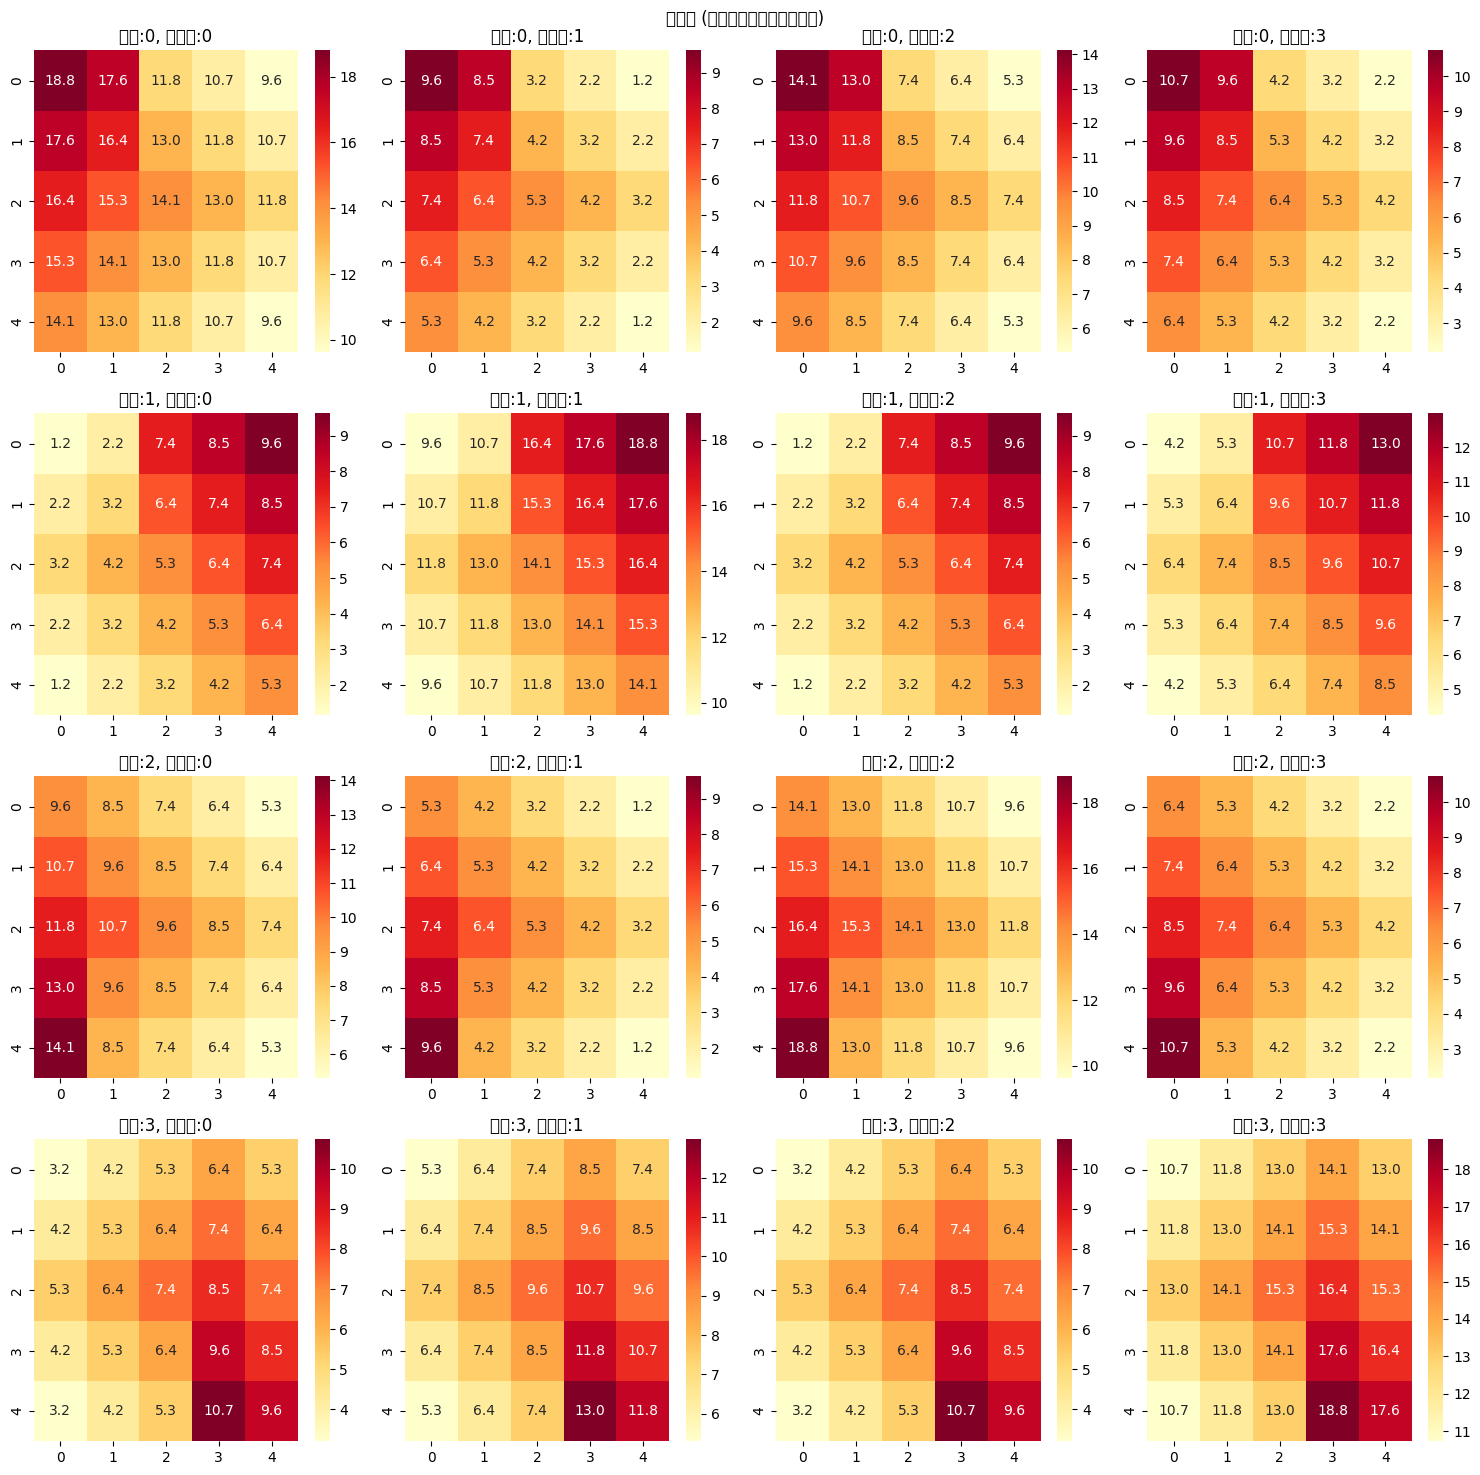

/var/folders/gz/0gxv2qld2094b0b1mp3z79tc0000gn/T/ipykernel_91427/2592227891.py:116: UserWarning: Glyph 20056 (\N{CJK UNIFIED IDEOGRAPH-4E58}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gz/0gxv2qld2094b0b1mp3z79tc0000gn/T/ipykernel_91427/2592227891.py:116: UserWarning: Glyph 23458 (\N{CJK UNIFIED IDEOGRAPH-5BA2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gz/0gxv2qld2094b0b1mp3z79tc0000gn/T/ipykernel_91427/2592227891.py:116: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gz/0gxv2qld2094b0b1mp3z79tc0000gn/T/ipykernel_91427/2592227891.py:116: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gz/0gxv2qld2094b0b1mp3z79tc0000gn/T/ipykernel_91427/2592227891.py:116: UserWarning: Glyph 22320 (\N{CJK UNIFIED IDEOGRAPH-5730}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gz

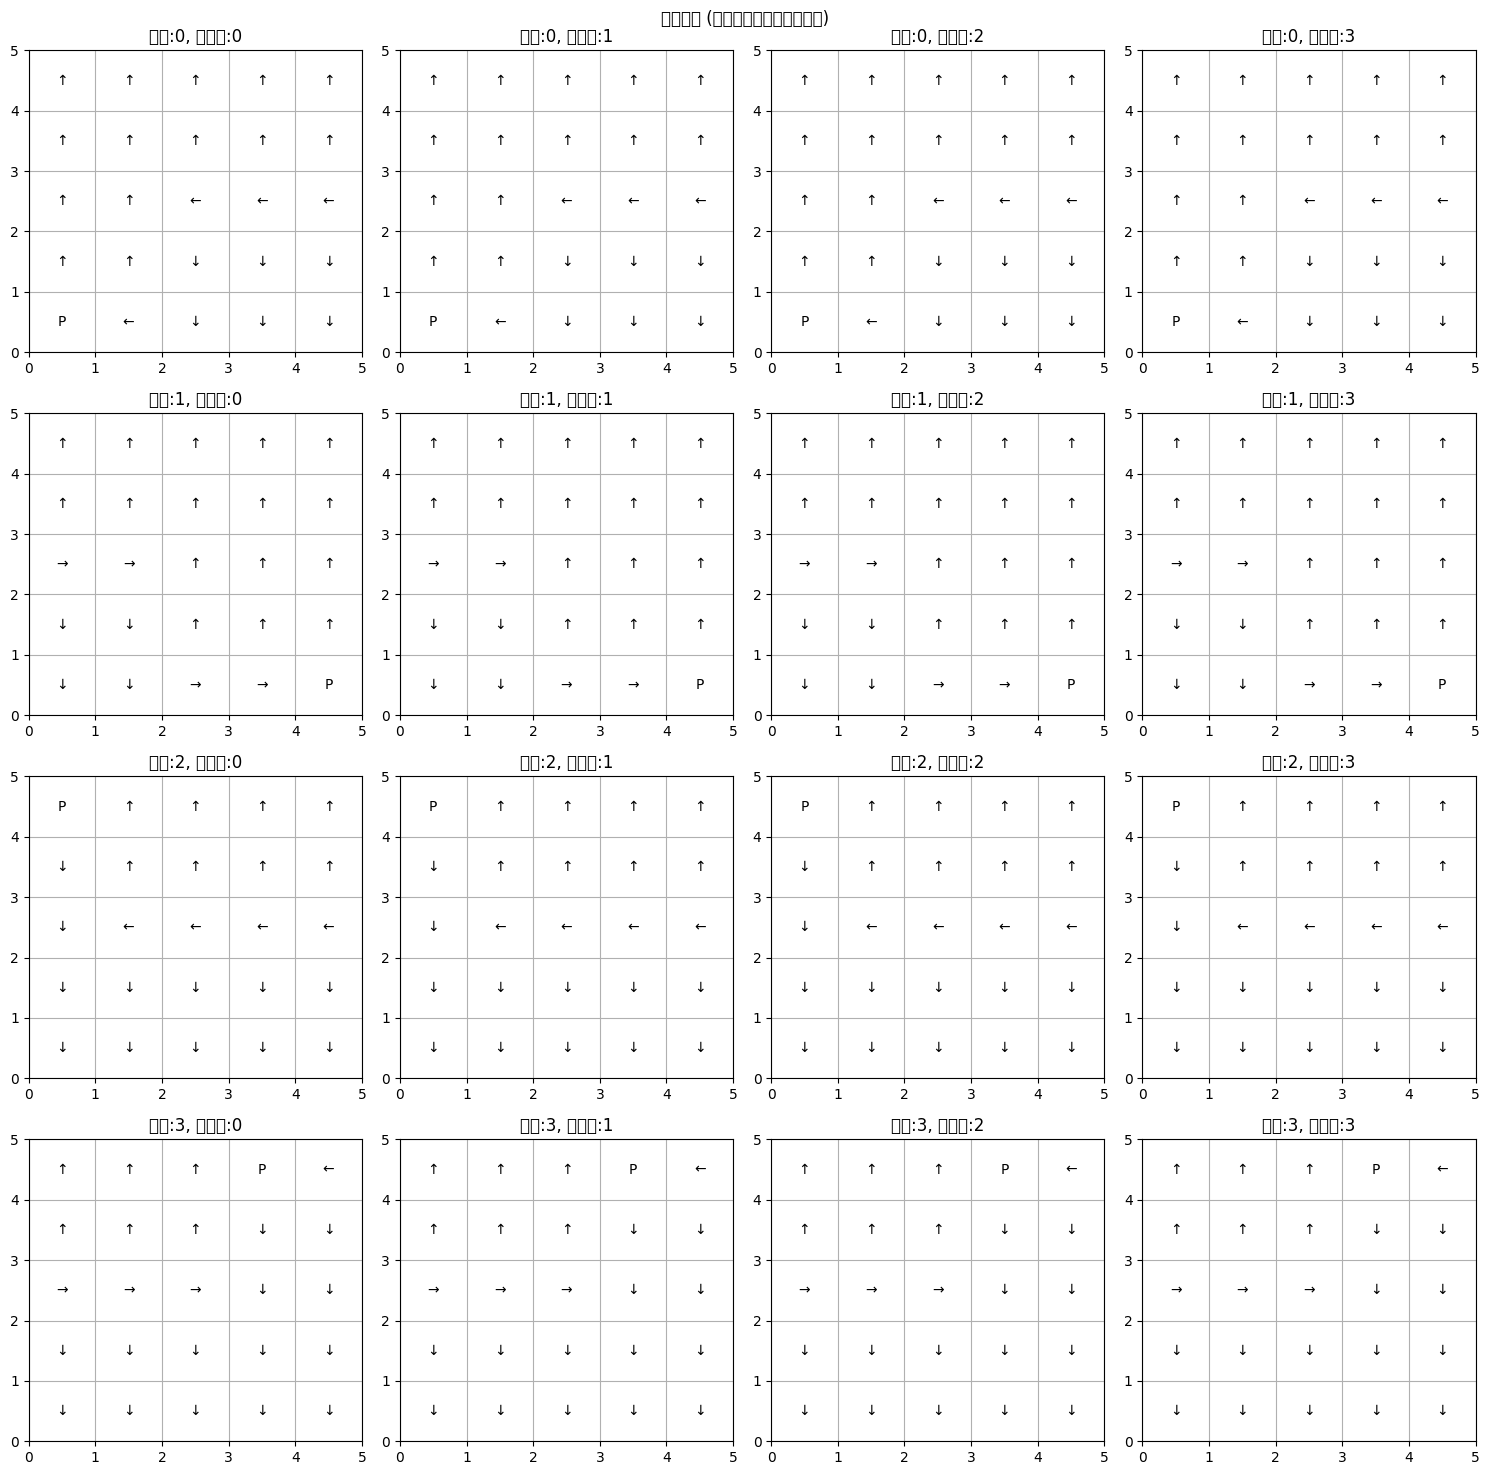

KeyboardInterrupt: 

In [13]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns

class ValueIterationAgent:
    def __init__(self, env, gamma=0.99, theta=1e-6):
        """初始化价值迭代代理
        
        Args:
            env: OpenAI Gym环境
            gamma: 折扣因子，决定未来奖励的重要性
            theta: 收敛阈值
        """
        self.env = env
        self.gamma = gamma
        self.theta = theta
        # 初始化价值函数为零
        self.values = np.zeros(env.observation_space.n)
        # 初始化策略
        self.policy = np.zeros(env.observation_space.n, dtype=int)
        
    def value_iteration(self):
        """执行价值迭代算法"""
        iteration = 0
        while True:
            # 保存当前的价值函数以检查收敛
            old_values = self.values.copy()
            
            # 对每个状态进行更新
            for state in range(self.env.observation_space.n):
                # 初始化当前状态的最大价值
                max_value = float('-inf')
                best_action = 0
                
                # 尝试所有可能的动作
                for action in range(self.env.action_space.n):
                    value = 0
                    
                    # 获取转移概率和奖励
                    # P[s][a] = [(probability, next_state, reward, done), ...]
                    for prob, next_state, reward, done in self.env.P[state][action]:
                        # 计算贝尔曼方程
                        value += prob * (reward + self.gamma * 
                                      (0 if done else self.values[next_state]))
                    
                    # 更新最大价值和最佳动作
                    if value > max_value:
                        max_value = value
                        best_action = action
                
                # 更新价值函数和策略
                self.values[state] = max_value
                self.policy[state] = best_action
            
            iteration += 1
            
            # 检查是否收敛
            if np.max(np.abs(self.values - old_values)) < self.theta:
                break
                
        return iteration
    def visualize_values(self):
        """可视化价值函数"""
        # 创建一个图形，包含多个子图来展示不同状态的值
        fig, axes = plt.subplots(4, 4, figsize=(15, 15))
        fig.suptitle('状态值 (按乘客位置和目的地划分)')
        
        # 遍历所有乘客位置和目的地组合
        for passenger_idx in range(4):
            for dest_idx in range(4):
                # 提取对应这个组合的状态值
                values_slice = np.zeros((5, 5))
                for i in range(5):
                    for j in range(5):
                        state_idx = self.env.encode(i, j, passenger_idx, dest_idx)
                        values_slice[i, j] = self.values[state_idx]
                
                # 在对应的子图中显示热力图
                ax = axes[passenger_idx, dest_idx]
                sns.heatmap(values_slice, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax)
                ax.set_title(f'乘客:{passenger_idx}, 目的地:{dest_idx}')
        
        plt.tight_layout()
        plt.show()

    def visualize_policy(self):
        """可视化策略"""
        # 动作映射
        action_symbols = ['↓', '↑', '→', '←', 'P', 'D']
        
        # 创建子图
        fig, axes = plt.subplots(4, 4, figsize=(15, 15))
        fig.suptitle('最优策略 (按乘客位置和目的地划分)')
        
        # 遍历所有乘客位置和目的地组合
        for passenger_idx in range(4):
            for dest_idx in range(4):
                policy_grid = np.zeros((5, 5), dtype=object)
                for i in range(5):
                    for j in range(5):
                        state_idx = self.env.encode(i, j, passenger_idx, dest_idx)
                        policy_grid[i, j] = action_symbols[self.policy[state_idx]]
                
                # 在对应的子图中显示策略
                ax = axes[passenger_idx, dest_idx]
                for i in range(5):
                    for j in range(5):
                        ax.text(j + 0.5, i + 0.5, policy_grid[i, j], 
                            ha='center', va='center')
                ax.set_title(f'乘客:{passenger_idx}, 目的地:{dest_idx}')
                ax.grid(True)
                ax.set_xticks(range(6))
                ax.set_yticks(range(6))
        
        plt.tight_layout()
        plt.show()
    
   
def run_episode(env, agent):
    """运行一个回合并返回总奖励"""
    state, _ = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        action = agent.policy[state]
        next_state, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        state = next_state
        
    return total_reward

# 主程序
if __name__ == "__main__":
    # 创建出租车环境
    # 创建环境时需要去掉 TimeLimit 包装器
    env = gym.make('Taxi-v3', render_mode='human').unwrapped

    # 现在环境对象应该有 P 属性了
    agent = ValueIterationAgent(env)
    iterations = agent.value_iteration()
    
    # 创建并训练代理
    print(f"收敛于 {iterations} 次迭代后")
    
    # 可视化结果
    agent.visualize_values()
    agent.visualize_policy()
    
    # 评估策略
    n_episodes = 100
    rewards = [run_episode(env, agent) for _ in range(n_episodes)]
    print(f"平均奖励: {np.mean(rewards):.2f} +/- {np.std(rewards):.2f}")

    # 展示一个回合
    state, _ = env.reset()
    env.render()
    done = False
    
    while not done:
        action = agent.policy[state]
        state, reward, done, truncated, _ = env.step(action)
        env.render()